# Variational Auto Encoder with disentanglement

L'objectif de ce TP est de classifier des images de MNIST (Modified National Institute of Standards and Technology) database en dix sets ( de 0 à 9), en utilisant un variational auto-encoder algorithme du package Torch.

In [1]:
from __future__ import print_function

%config IPCompleter.greedy=True

import argparse, torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

batchsize = 128
epochs = 10
loginterval = 10
cuda = torch.cuda.is_available()

SEED = 1
torch.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batchsize, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', train=False, transform=transforms.ToTensor()),
    batch_size=batchsize, shuffle=True, **kwargs)

# Model

In [2]:
class VAE(nn.Module):
    """
    Variational Auto Encoder model, with one hidden layer.
    
    Attributes
    ----------
    encoder : torch.nn.modules.linear.Sequential
        The first fully-connected layer.
    decoder : torch.nn.modules.linear.Sequential
        The second fully connected layer.

    """       
    def __init__(self):
        super(VAE, self).__init__()

        # create using nn.Sequential()
        # decoder :FC (20 -> 400), RELU activation; FC (400, 784)
        self.decoder = nn.Sequential(nn.Linear(20, 400), nn.ReLU(), nn.Linear(400, 784))
        # and without using nn.Sequential, an encoder
        #FC (784 -> 400), RELU activation
        # then in parallel a FC (400, 20) for each mu / logvar
        self.encoder = nn.Linear(784,400)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(400,20)
        self.fc2 = nn.Linear(400,20)

    def encode(self, x):
        """
        The encode pass.
        """
        x_relu = self.relu(self.encoder(x))
        mu = self.fc1(x_relu)
        logvar = self.fc2(x_relu)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        Reparameterize the parameters.
        """
        # sample
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        
        return eps.mul(std).add_(mu)

    def decode(self, z):
        """
        The decode pass.
        """
        return torch.sigmoid(self.decoder(z))

    def forward(self, x):
        """
        The forward pass of the global network.
        """
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Loss function

In [3]:
def loss_function(recon_batch, x, mu, logvar, beta):
    """
    Compute the bce as the binary-cross entropy across the batch as a sum.
    """
    loss = nn.BCELoss(reduction='sum')
    bce = loss(recon_batch, x)
    #   Kullback-Leibler divergence losses summed over all elements and batch
    kld = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # the beta factor allows disentanglement for values >>1
    return bce+kld*beta

# Train

In [4]:
losses = []
encode_grad = []
fc1_grad = []
fc2_grad = []
def train(epoch, beta):
    """
    The train phase of the model.
    """
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data.view(-1, 784), mu, logvar, beta)
        losses.append(loss.item())
        loss.backward()
        encode_grad.append(model.encoder.weight.grad.mean())
        fc1_grad.append(model.fc1.weight.grad.mean())
        fc2_grad.append(model.fc2.weight.grad.mean())
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % loginterval == 0:
            print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.1f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)), end='')

    print(' Average loss: {:.1f}'.format(
         train_loss / len(train_loader.dataset)), end='')

# Test

In [5]:
def test(epoch, beta):
    """
    The test phase of the model.
    """
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data.view(-1, 784), mu, logvar,beta)

            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batchsize, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'resultsVAE/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print(' Test loss: {:.1f}'.format(test_loss))

In [6]:
beta = 10
for epoch in range(1, epochs + 1):
    train(epoch, beta)
    test(epoch, beta)
    with torch.no_grad():
         sample = torch.randn(64, 20).to(device)
         sample = model.decode(sample).cpu()
         save_image(sample.view(64, 1, 28, 28), 'resultsVAE/sample_' + str(epoch) + '.png')    

 Train Epoch: 1 [58880/60000 (98%)]	Loss: 197.3 Average loss: 212.0 Test loss: 197.7
 Train Epoch: 2 [58880/60000 (98%)]	Loss: 194.2 Average loss: 195.0 Test loss: 192.0
 Train Epoch: 3 [58880/60000 (98%)]	Loss: 187.5 Average loss: 190.7 Test loss: 189.0
 Train Epoch: 4 [58880/60000 (98%)]	Loss: 186.8 Average loss: 189.0 Test loss: 188.0
 Train Epoch: 5 [58880/60000 (98%)]	Loss: 188.9 Average loss: 188.1 Test loss: 186.8
 Train Epoch: 6 [58880/60000 (98%)]	Loss: 182.5 Average loss: 187.3 Test loss: 186.5
 Train Epoch: 7 [58880/60000 (98%)]	Loss: 186.3 Average loss: 186.8 Test loss: 186.2
 Train Epoch: 8 [58880/60000 (98%)]	Loss: 187.8 Average loss: 186.4 Test loss: 185.3
 Train Epoch: 9 [58880/60000 (98%)]	Loss: 180.6 Average loss: 186.0 Test loss: 185.4
 Train Epoch: 10 [58880/60000 (98%)]	Loss: 189.2 Average loss: 185.5 Test loss: 184.8


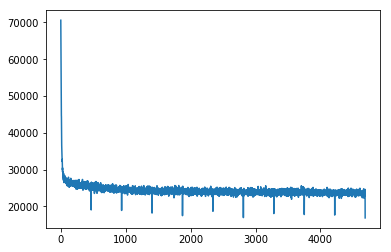

In [7]:
plt.plot(losses)

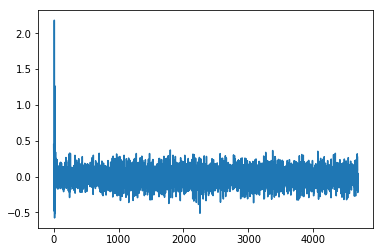

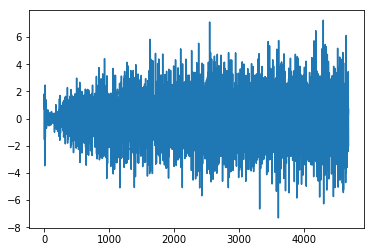

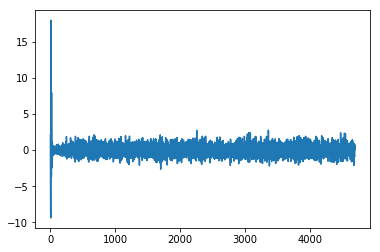

In [8]:
#plot the gradient mean value for each FC layer across training
#plot the gradient mean value for each FC layer across training
#plt.plot(gradients)
plt.plot(encode_grad)
plt.show()
plt.plot(fc1_grad)
plt.show()
plt.plot(fc2_grad)
plt.show()